In [28]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from download_data import download_data

df = pd.read_csv(download_data())
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1319 entries, 0 to 1318
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Age                       1319 non-null   int64  
 1   Gender                    1319 non-null   int64  
 2   Heart rate                1319 non-null   int64  
 3   Systolic blood pressure   1319 non-null   int64  
 4   Diastolic blood pressure  1319 non-null   int64  
 5   Blood sugar               1319 non-null   float64
 6   CK-MB                     1319 non-null   float64
 7   Troponin                  1319 non-null   float64
 8   Result                    1319 non-null   object 
dtypes: float64(3), int64(5), object(1)
memory usage: 92.9+ KB


In [3]:
df.head()

,Age,Gender,Heart rate,Systolic blood pressure,Diastolic blood pressure,Blood sugar,CK-MB,Troponin,Result
0,64,1,66,160,83,160.0,1.80,0.012,negative
1,21,1,94,98,46,296.0,6.75,1.060,positive
2,55,1,64,160,77,270.0,1.99,0.003,negative
3,64,1,70,120,55,270.0,13.87,0.122,positive
4,55,1,64,112,65,300.0,1.08,0.003,negative


- No missing entries, great
- For this analysis, I want to take a look if age has any impact on the rate of attacks
- My hypotesis is that is has and that with age the rate of heart attacks increases, it should also have higher rates with high CK-MB or Troponin

In [4]:
df["Result"].unique().tolist()

['negative', 'positive']

In [29]:
df["Result"] = df["Result"].map({"positive": 1, "negative": 0})

df = df.drop(columns=["Gender", "Heart rate", "Systolic blood pressure", "Diastolic blood pressure"])

y = df["Result"]
x = df.drop(columns=["Result"])

df.head()

,Age,Blood sugar,CK-MB,Troponin,Result
0,64,160.0,1.80,0.012,0
1,21,296.0,6.75,1.060,1
2,55,270.0,1.99,0.003,0
3,64,270.0,13.87,0.122,1
4,55,300.0,1.08,0.003,0


In [43]:
print(x.head())
print("---" * 20)
print()
print(y.head())

   Age  Blood sugar  CK-MB  Troponin
0   64        160.0   1.80     0.012
1   21        296.0   6.75     1.060
2   55        270.0   1.99     0.003
3   64        270.0  13.87     0.122
4   55        300.0   1.08     0.003
------------------------------------------------------------

0    0
1    1
2    0
3    1
4    0
Name: Result, dtype: int64


   Age  Blood sugar  CK-MB  Troponin
0   64        160.0   1.80     0.012
1   21        296.0   6.75     1.060
2   55        270.0   1.99     0.003
3   64        270.0  13.87     0.122
4   55        300.0   1.08     0.003


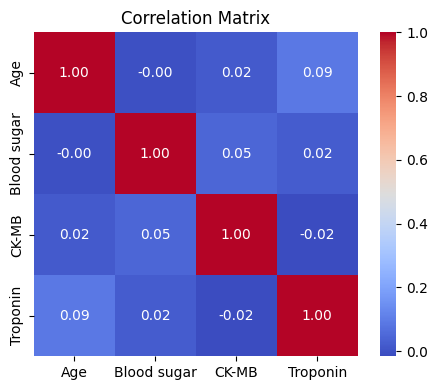

In [31]:


print(x.head())

# lets plot the correlation matrix
plt.figure(figsize=(5, 4))
sns.heatmap(x.corr(), annot=True, fmt=".2f", cmap="coolwarm", square=True)
plt.title("Correlation Matrix")
plt.tight_layout()
plt.show()

In [40]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

from sklearn.linear_model import LogisticRegression

model = LogisticRegression()
model.fit(x_train, y_train)

,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True
,intercept_scaling,1
,class_weight,None
,random_state,None
,solver,'lbfgs'
,max_iter,100
,multi_class,'deprecated'


In [ ]:
for name, coef, odds in zip(x.columns, model.coef_[0], np.exp(model.coef_[0])):
    print(f"{name:20s}  coef = {coef:7.3f}  odds ratio = {odds:10.2f}")


Age                   coef =   0.049  odds ratio =       1.05
Blood sugar           coef =  -0.001  odds ratio =       1.00
CK-MB                 coef =   0.384  odds ratio =       1.47
Troponin              coef =   6.830  odds ratio =     925.29


- The coefficient for Troponin is very high - something is wrong, unless high Troponin means certain heart attack
- We also see that Blood sugar has almost no effect on attack rate, lets confirm that and not use it for the model

In [48]:
df["troponin_bin"] = pd.cut(df["Troponin"], bins=[0, 0.1, 0.5, 1, 3, 6, 10.3])

print(pd.crosstab(df["troponin_bin"], df["Result"]))
print("---" * 20)
print(pd.crosstab(df["troponin_bin"], df["Result"], normalize="index"))

Result          0    1
troponin_bin          
(0.0, 0.1]    507  502
(0.1, 0.5]      1  111
(0.5, 1.0]      0   67
(1.0, 3.0]      0   99
(3.0, 6.0]      0   18
(6.0, 10.3]     1   13
------------------------------------------------------------
Result               0         1
troponin_bin                    
(0.0, 0.1]    0.502478  0.497522
(0.1, 0.5]    0.008929  0.991071
(0.5, 1.0]    0.000000  1.000000
(1.0, 3.0]    0.000000  1.000000
(3.0, 6.0]    0.000000  1.000000
(6.0, 10.3]   0.071429  0.928571


- This and some digging in medical data confirms the susspicion, if Troponin is high ( generaly >0.1 ) it means a very high chance of an attack

In [49]:
df["blood sugar bin"] = pd.cut(df["Blood sugar"], bins=[35, 70, 100, 140, 200, 300, 400, 541])

print(pd.crosstab(df["blood sugar bin"], df["Result"]))
print("---" * 20)
print(pd.crosstab(df["blood sugar bin"], df["Result"], normalize="index"))

Result             0    1
blood sugar bin          
(35, 70]           5   11
(70, 100]        154  247
(100, 140]       160  270
(140, 200]        89  142
(200, 300]        67   98
(300, 400]        24   30
(400, 541]        10   11
------------------------------------------------------------
Result                  0         1
blood sugar bin                    
(35, 70]         0.312500  0.687500
(70, 100]        0.384040  0.615960
(100, 140]       0.372093  0.627907
(140, 200]       0.385281  0.614719
(200, 300]       0.406061  0.593939
(300, 400]       0.444444  0.555556
(400, 541]       0.476190  0.523810


- Yes, it is as I have thought - blood sugar has almost no effect on the rate, lets then exclude it from the model and retrain it

In [ ]:
x = x.drop(columns=["Blood sugar"])
x.head()

,Age,CK-MB,Troponin
0,64,1.80,0.012
1,21,6.75,1.060
2,55,1.99,0.003
3,64,13.87,0.122
4,55,1.08,0.003


In [53]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

model = LogisticRegression()
model.fit(x_train, y_train)

,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True
,intercept_scaling,1
,class_weight,None
,random_state,None
,solver,'lbfgs'
,max_iter,100
,multi_class,'deprecated'


In [ ]:
for name, coef, odds in zip(x.columns, model.coef_[0], np.exp(model.coef_[0])):
    print(f"{name:20s}  coef = {coef:7.3f}  odds ratio = {odds:10.2f}")

Age                   coef =   0.049  odds ratio =       1.05
CK-MB                 coef =   0.385  odds ratio =       1.47
Troponin              coef =   6.840  odds ratio =     934.29


### What this tells us

- **Age** (1,05) - for every 1 unit increase of age, the odds of an attack happening increase by 5%
- **CK_MB** (1,47) - for every 1 unit increase of this variable, the odds of an attack happening increase by 47%
- **Troponin** (934,29) - as we saw previously, high troponin almost always means an attack - thats why the odds increase by 93429% 

Accuracy:  0.7992424242424242
Precision: 0.8313253012048193
Recall:    0.8466257668711656
F1 Score:  0.8389057750759878
ROC AUC:   0.8896009232825123
------------------------------------------------------------
Accuracy:  0.7954545454545454
Precision: 0.7823834196891192
Recall:    0.9263803680981595
F1 Score:  0.848314606741573
ROC AUC:   0.8896009232825123


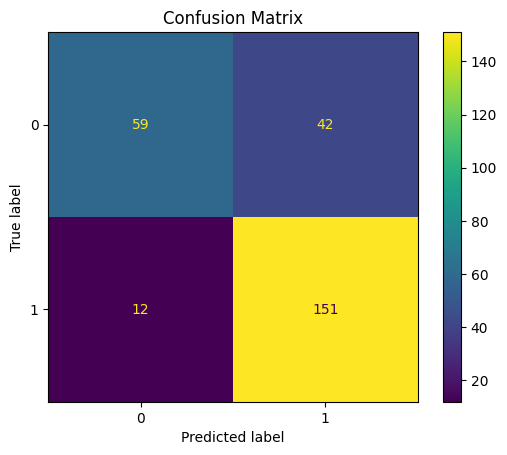

In [67]:
y_pred_proba = model.predict_proba(x_test)[:, 1]

# Class predictions (default threshold = 0.5)
y_pred_class = (y_pred_proba > 0.5).astype(int)

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

print("Accuracy: ", accuracy_score(y_test, y_pred_class))
print("Precision:", precision_score(y_test, y_pred_class))
print("Recall:   ", recall_score(y_test, y_pred_class))
print("F1 Score: ", f1_score(y_test, y_pred_class))
print("ROC AUC:  ", roc_auc_score(y_test, y_pred_proba))
print("---" * 20)


y_pred_class = (y_pred_proba > 0.4).astype(int)

print("Accuracy: ", accuracy_score(y_test, y_pred_class))
print("Precision:", precision_score(y_test, y_pred_class))
print("Recall:   ", recall_score(y_test, y_pred_class))
print("F1 Score: ", f1_score(y_test, y_pred_class))
print("ROC AUC:  ", roc_auc_score(y_test, y_pred_proba))


from sklearn.metrics import ConfusionMatrixDisplay

ConfusionMatrixDisplay.from_predictions(y_test, y_pred_class)
plt.title("Confusion Matrix")
plt.show()



# Model Performance Metrics Explained

## Overview of Results (Threshold = 0.4)

### Accuracy (79.5%)
**Formula**: (TP + TN) / (TP + TN + FP + FN)

The proportion of correct predictions out of all predictions made. While useful for balanced datasets, it can be misleading when classes are imbalanced (which isn't the case here).

### Precision (78.2%)
**Formula**: TP / (TP + FP)

Of all patients predicted to have a heart attack, 78.2% actually did. This measures how many of our positive predictions were correct - important for avoiding unnecessary anxiety and treatments.

### Recall/Sensitivity (92.6%)
**Formula**: TP / (TP + FN)

Of all patients who actually had heart attacks, we correctly identified 92.6%. This is crucial in medical diagnosis as missing a heart attack (false negative) can be life-threatening.

### F1 Score (84.8%)
**Formula**: 2 × (Precision × Recall) / (Precision + Recall)

The harmonic mean of precision and recall, providing a balanced measure when both false positives and false negatives matter. It's particularly useful when dealing with imbalanced datasets.

## Clinical Interpretation

**Medical Context**: The 40% threshold prioritizes recall over precision, which is appropriate for heart attack prediction where missing a case (false negative) is far more dangerous than a false alarm (false positive). The high recall ensures we catch most actual heart attacks, while maintaining reasonable precision to avoid excessive false alarms.

**Legend**:
- TP (True Positives): Correctly predicted heart attacks
- TN (True Negatives): Correctly predicted no heart attack
- FP (False Positives): Incorrectly predicted heart attack
- FN (False Negatives): Missed heart attacks# Model Performance Metrics Explained

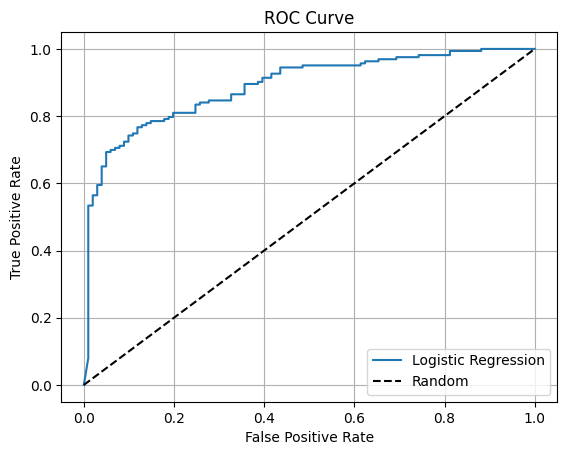

In [68]:
from sklearn.metrics import roc_curve

fpr, tpr, _ = roc_curve(y_test, y_pred_proba)

plt.plot(fpr, tpr, label="Logistic Regression")
plt.plot([0, 1], [0, 1], 'k--', label="Random")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.grid(True)
plt.show()


## What is an ROC Curve?

The **Receiver Operating Characteristic (ROC) curve** is a fundamental evaluation tool in binary classification that plots the relationship between:
- **True Positive Rate (TPR)** or Sensitivity on the y-axis: TP/(TP+FN) - the proportion of actual positives correctly identified
- **False Positive Rate (FPR)** on the x-axis: FP/(FP+TN) - the proportion of actual negatives incorrectly classified as positive

### Key Interpretations:

- **Perfect Classifier**: Would have a curve that goes straight up to (0,1) then across to (1,1) - AUC = 1.0
- **Random Classifier**: Represented by the diagonal line from (0,0) to (1,1) - AUC = 0.5

## ROC Curve Analysis

- **High AUC**: The curve is positioned well above the diagonal "random" line, indicating strong discriminative ability
- **Strong Early Performance**: The curve rises steeply near the origin, meaning the model achieves high true positive rates while maintaining low false positive rates
- **Medical Context Appropriateness**: The curve demonstrates that our 40% threshold choice is well-justified - it allows us to catch more true cases (higher sensitivity) at the cost of some false positives, which aligns with medical best practices where missing a heart attack is far more dangerous than a false alarm
- **Feature Quality**: The strong performance validates our feature selection, particularly the importance of Troponin levels, Age, and CK-MB in predicting heart attacks

### Clinical Relevance:

In medical diagnosis, the ROC curve helps us understand the trade-off between catching all true cases (sensitivity) versus avoiding false alarms (specificity). Our model's strong performance suggests it can effectively distinguish between patients at high and low risk of heart attacks, making it a valuable diagnostic aid.

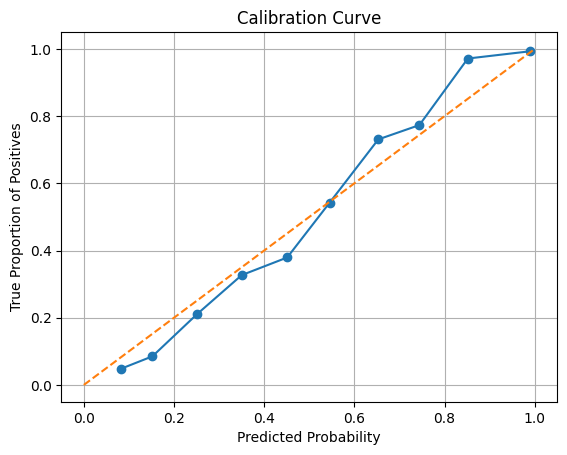

In [79]:
from sklearn.calibration import calibration_curve

prob_true, prob_pred = calibration_curve(y, df['predicted_proba'], n_bins=10)

plt.plot(prob_pred, prob_true, marker='o')
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlabel("Predicted Probability")
plt.ylabel("True Proportion of Positives")
plt.title("Calibration Curve")
plt.grid(True)
plt.show()



### What is a Calibration Curve?

A **calibration curve** (also called a reliability diagram) evaluates how well the predicted probabilities from a classification model align with the actual observed frequencies. It plots:

- **X-axis**: Predicted probabilities (model's confidence scores)
- **Y-axis**: True proportion of positive cases in each probability bin

### How to Interpret Calibration Curves

- **Perfect Calibration**: The curve follows the diagonal line (y = x)
    - If the model predicts 70% probability, then 70% of those cases should actually be positive
- **Above the Diagonal**: Model is **under-confident** (conservative)
    - Predicts 60% but actual rate is 80% - model underestimates risk
- **Below the Diagonal**: Model is **over-confident** (aggressive)
    - Predicts 80% but actual rate is 60% - model overestimates risk

A well-calibrated model ensures that when we say there's a 40% chance of heart attack, approximately 40% of those patients will actually experience one.